# __Convolutional Neural Network (CNN)__

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Custom libraries
import sys
sys.path.append('..')
from functions.models import *

### Load data

In [2]:
X_train = pd.read_csv('../data/X_train.tsv', sep='\t')
X_test = pd.read_csv('../data/X_test.tsv', sep='\t')
X_val = pd.read_csv('../data/X_val.tsv', sep='\t')

y_train = pd.read_csv('../data/y_train.tsv', sep='\t')
y_test = pd.read_csv('../data/y_test.tsv', sep='\t')
y_val = pd.read_csv('../data/y_val.tsv', sep='\t')

# Check
print(X_train.head())
print(y_train.head())

                                             comment
0  everyone think he laugh screwing people instea...
1                                               fuck
2                               make feel threatened
3                              dirty southern wanker
4  omg good enough help u playoff dumbass bronco ...
   label
0     27
1      2
2     14
3      3
4     26


### Tokenization, Padding and Sequencing

In [3]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Obtain padded train and test sequences, length of longest sequence and vocabulary size
train_padded, val_padded, max_seq_len, vocab_size, tokenizer = tokenization(tokenizer, X_train, X_val, "comment")

In [10]:
# Lista de emociones
cat_labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
    'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
    'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
    'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]
num_labels = len(cat_labels)

# Convertir las etiquetas a un formato adecuado para el entrenamiento
y_train_categorical = to_categorical(y_train, num_classes=num_labels)
y_test_categorical = to_categorical(y_test, num_classes=num_labels)
y_val_categorical = to_categorical(y_val, num_classes=num_labels)

### Model Building

In [63]:
# Crear el modelo
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=200, input_length=max_seq_len))

# Convolutional layers
model.add(Conv1D(filters=100, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.7))

# Flatten and classifier
model.add(Flatten())
model.add(Dropout(0.7))
model.add(Dense(128, activation="relu"))

# Output layer
model.add(Dense(num_labels, activation="softmax"))  # Usar softmax para clasificación múltiple

# Compilar el modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Resumen del modelo
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 20, 200)           1272600   
                                                                 
 conv1d_7 (Conv1D)           (None, 20, 100)           100100    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 10, 100)          0         
 1D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 10, 100)           0         
                                                                 
 flatten_7 (Flatten)         (None, 1000)              0         
                                                                 
 dropout_15 (Dropout)        (None, 1000)              0         
                                                      

### Model Training

In [64]:
# Definir EarlyStopping y ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)
mc = ModelCheckpoint(filepath='../trained_models/cnn.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Entrenar el modelo
history = model.fit(
    train_padded, y_train_categorical,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(val_padded, y_val_categorical),
    callbacks=[es, mc]
)

Epoch 1/50
622/624 [============================>.] - ETA: 0s - loss: 2.8682 - accuracy: 0.1938
Epoch 1: val_loss improved from inf to 2.50006, saving model to ../trained_models\cnn.h5
624/624 [==============================] - 17s 26ms/step - loss: 2.8676 - accuracy: 0.1941 - val_loss: 2.5001 - val_accuracy: 0.3110
Epoch 2/50
623/624 [============================>.] - ETA: 0s - loss: 2.5242 - accuracy: 0.2988
Epoch 2: val_loss improved from 2.50006 to 2.31665, saving model to ../trained_models\cnn.h5
624/624 [==============================] - 16s 25ms/step - loss: 2.5244 - accuracy: 0.2988 - val_loss: 2.3167 - val_accuracy: 0.3480
Epoch 3/50
623/624 [============================>.] - ETA: 0s - loss: 2.3672 - accuracy: 0.3328
Epoch 3: val_loss improved from 2.31665 to 2.27070, saving model to ../trained_models\cnn.h5
624/624 [==============================] - 15s 24ms/step - loss: 2.3669 - accuracy: 0.3328 - val_loss: 2.2707 - val_accuracy: 0.3682
Epoch 4/50
622/624 [==================

### Model Validation

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

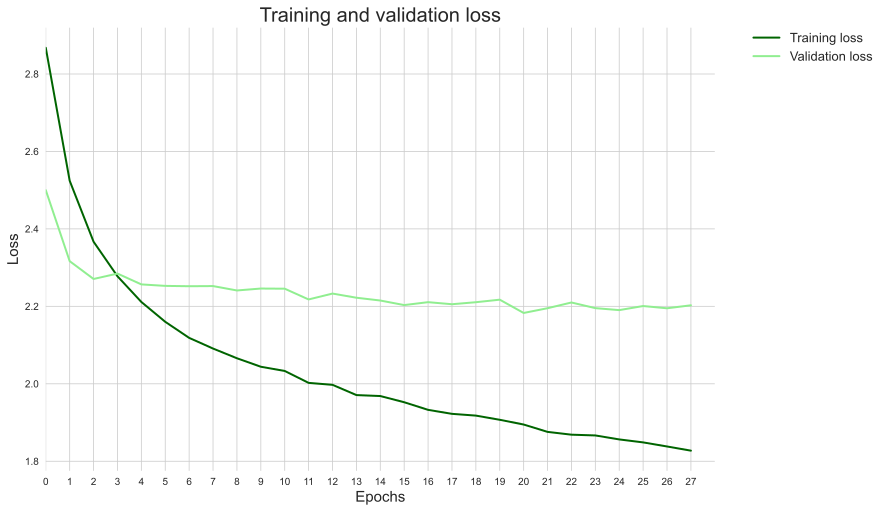

In [72]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkgreen", "lightgreen", "Loss", 1)

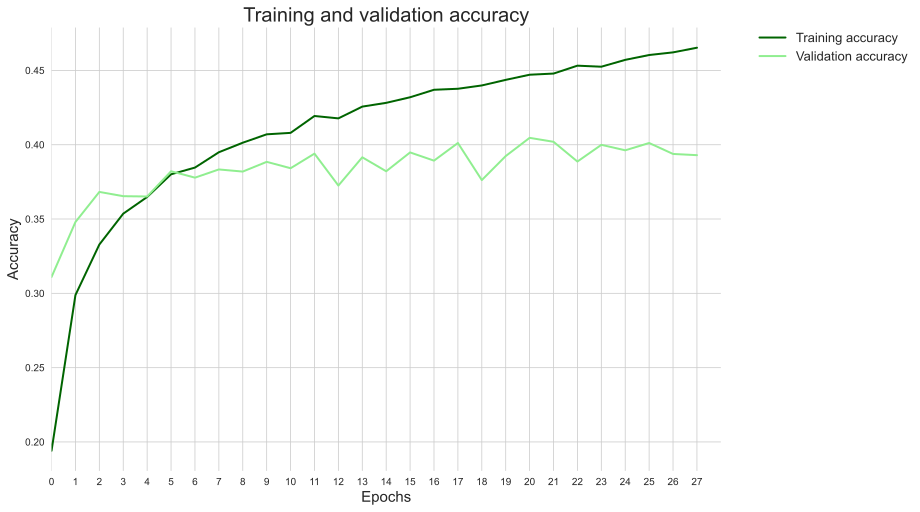

In [68]:

# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "darkgreen", "lightgreen", "Accuracy", 1)

### Model Evaluation

In [7]:
# Apply tokenizer to test set
test_sequences = tokenizer.texts_to_sequences(X_test["comment"])
test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

In [8]:
cnn_model = load_model('../trained_models/cnn.h5')

In [11]:
# Evaluate model on test set
loss_test, acc_test = cnn_model.evaluate(test_padded, np.array(y_test_categorical))
print("Test loss: {:.4f}".format(loss_test))  
print("Test accuracy: {:.4f}".format(acc_test))

152/152 [==============================] - 1s 3ms/step - loss: 2.1923 - accuracy: 0.3998
Test loss: 2.1923
Test accuracy: 0.3998


In [12]:
real_labels = y_test['label'].values
len(real_labels)

4833

In [13]:
predictions = cnn_model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)
len(predicted_labels)

152/152 [==============================] - 1s 3ms/step


4833

In [14]:
len(cat_labels)

28

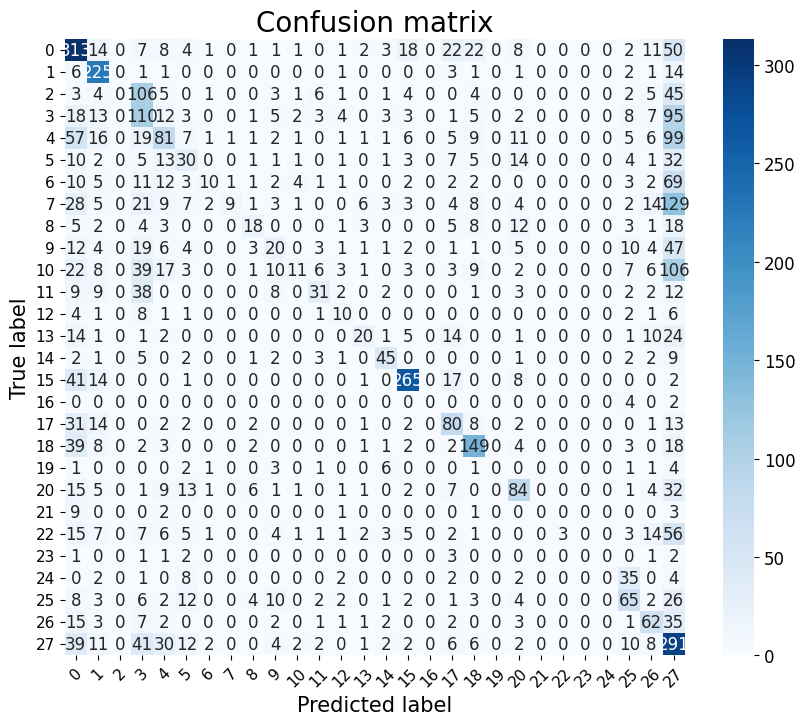

In [17]:
#conf_matrix = confusion_matrix(y_test, predicted_labels)
unique_labels = np.unique(real_labels)
plot_confusion_matrix(real_labels, predicted_labels, unique_labels, cmap="Blues")